<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - Wine Recommender System <br> [Part 3 of 3]

## Contents:
- [Modeling](##Modeling)
- [Hyperparameter Tuning](##Hyperparameter-Tuning)
- [Conclusion](##Conclusion)
- [Limitations](##Limitations)
- [Recommendations](##Recommendations)

---
## Modeling
---

In [3]:
# Importing Libraries

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, KFold, GridSearchCV
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, NMF, CoClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
df = pd.read_pickle('../data/wine_reviews_clean.pkl')

In [5]:
# Assign a unique ID to each wine
df['wine_id'] = df.index

# Assign a unique ID to each taster
taster_ids = df['taster_name'].drop_duplicates().reset_index(drop=True)
df['user_id'] = df['taster_name'].map(lambda taster: taster_ids[taster_ids == taster].index[0])

# Save the updated DataFrame as a pickle file
df.to_pickle('../data/wine_reviews_clean.pkl')

# Convert the dataframe to a user preferences format
user_prefs = df[['user_id', 'wine_id', 'points']]

# Save user preferences dataframe
user_prefs[['user_id', 'wine_id', 'points']].to_csv("../data/user_prefs.csv", index=False)

# Load data
reader = Reader(line_format='user item rating', sep=',', rating_scale=(90, 100), skip_lines=1)
data = Dataset.load_from_file("../data/user_prefs.csv", reader=reader)

The Surprise library may be used for building and evaluating collaborative filtering-based recommendation systems. It provides several built-in algorithms to experiment with and evaluate different recommendation strategies. The algorithms in this list include:

`Normal Predictor`: Predicts a random rating based on the distribution of the training set, which is assumed to be normal. It is mostly used for a baseline to compare with more advanced algorithms

`Baseline Predictor`: Predicts ratings based on the overall mean rating, user biases, and item biases. It's a basic yet effective model for handling user and item biases in collaborative filtering

`KNN Basic`: A collaborative filtering algorithm based on k-Nearest Neighbors, which uses the similarities between users or items to make recommendations. This is the most basic version of the KNN algorithm

`KNN with Means`: An extension of the KNN Basic algorithm, which takes into account the mean ratings of each user or item while computing similarities

`KNN with Z-score`: Another extension of the KNN Basic algorithm, which normalizes the ratings using the z-score normalization method while computing similarities

`KNN Baseline`: A more advanced version of the KNN Basic algorithm that considers both user and item biases while computing similarities

`SVD`: A matrix factorization technique that is particularly effective for sparse datasets

`Non-negative Matrix Factorization (NMF)`: Enforces non-negativity constraints on the factor matrices. This can be useful for certain types of data, such as when the ratings are only positive

`Co-Clustering`: A collaborative filtering algorithm that clusters both users and items simultaneously, allowing for the simultaneous grouping of users and items to discover latent structures

In [6]:
# Define the algorithms
algorithms = [
    ('Normal Predictor', NormalPredictor()),
    ('Baseline Predictor', BaselineOnly()),
    ('KNN Basic', KNNBasic()),
    ('KNN with Means', KNNWithMeans()),
    ('KNN with Z-score', KNNWithZScore()),
    ('KNN Baseline', KNNBaseline()),
    ('SVD', SVD()),
    ('Non-negative Matrix Factorization', NMF()),
    ('Co-Clustering', CoClustering()),
]

In [7]:
# K-Fold Cross-Validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=random.seed(42))

The threshold value determines the benchmark for wines to be considered relevant. 

We will set our threshold to be 91 points, which is the median of our dataset. A low threshold means that wines with lower ratings will be considered relevant, while a high threshold requires wines to have higher ratings to be considered relevant. 

When the threshold is low, precision might be high because many wines are considered relevant, but recall might be lower because fewer relevant wines are included in the top k recommendations. 

When the threshold is high, precision might be lower because only a few wines meet the high rating requirement, but recall might be higher because more of the relevant wines are included in the top k recommendations.
- `Precision@k` : Proportion of relevant wines among the top k recommendations, i.e. relevance of recommended wines
- `Recall@k` : Proportion of relevant wines among the top k recommendations out of all the relevant wines, i.e. coverage of relevant wines

A high precision means that the recommender is providing mostly relevant recommendations, which can be beneficial if users prefer a small, highly curated set of options.

A high recall means that the recommender is capturing most of the relevant items, which is useful if users want to ensure they are not missing out on any good options.

In [8]:
# Define Precision@k and Recall@k
def precision_recall_at_k(predictions, k=10, threshold=91):
    user_est_true = dict()
    for uid, _, true_r, est, _ in predictions:
        if uid not in user_est_true:
            user_est_true[uid] = []
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

We will now evaluate the performance of the above-mentioned algorithms.

In [9]:
def evaluate_algorithms(algorithms, data, k_fold):
    results = []
    for name, algo in algorithms:
        print(f"Evaluating {name}...")
        algo_results = cross_validate(algo, data, measures=['RMSE'], cv=k_fold, verbose=False)
        rmse = algo_results['test_rmse'].mean()

        # Precision and Recall
        precisions_list = []
        recalls_list = []
        for trainset, testset in k_fold.split(data):
            algo.fit(trainset)
            predictions = algo.test(testset)
            precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=91)

            precisions_list.append(sum(prec for prec in precisions.values()) / len(precisions))
            recalls_list.append(sum(rec for rec in recalls.values()) / len(recalls))

        precision = sum(precisions_list) / len(precisions_list)
        recall = sum(recalls_list) / len(recalls_list)

        results.append({
            'Algorithm': name,
            'RMSE': rmse,
            'Precision@k': precision,
            'Recall@k': recall,
        })
    return results
# Call the evaluate_algorithms function and store the results
k_fold = KFold(n_splits=5, shuffle=True, random_state=random.seed(42))
results = evaluate_algorithms(algorithms, data, k_fold)

Evaluating Normal Predictor...
Evaluating Baseline Predictor...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating KNN Basic...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd 

For our case, we will prioritise Precision@k as we will be seeking a smaller and more refined set of recommendations and are not concerned about potentially missing some relevant options.

In [10]:
results = pd.DataFrame(results)
print("Columns in the results DataFrame:", results.columns)
results = results[['Algorithm', 'RMSE', 'Precision@k', 'Recall@k']]
results

Columns in the results DataFrame: Index(['Algorithm', 'RMSE', 'Precision@k', 'Recall@k'], dtype='object')


,Algorithm,RMSE,Precision@k,Recall@k
0,Normal Predictor,2.175761,0.570322,0.163188
1,Baseline Predictor,1.614244,0.723860,0.096348
2,KNN Basic,1.632087,0.599323,0.198327
3,KNN with Means,1.632039,0.574854,0.192204
4,KNN with Z-score,1.632056,0.589415,0.198940
5,KNN Baseline,1.614310,0.721053,0.092490
6,SVD,1.614688,0.737544,0.066276
7,Non-negative Matrix Factorization,1.632061,0.597368,0.191382
8,Co-Clustering,1.632067,0.573216,0.185433


About 76.0% of the top 10 recommended wines are relevant to the user's preferences and the system is able to recommend about 6.9% of all relevant wines within the top 10 recommendations.

In other words, even though the recommender might not be capturing all relevant wines within the top 10 recommendations, it is providing accurate top recommendations to the user, which is our priority.

We will choose the SVD algorithm for tuning as it has the one of the **lowest RMSE** scores and the **highest Precision@k** score.

---
## Hyperparameter Tuning
---

In [11]:
# Set hyperparameters for SVD
param_grid = {
    'n_factors': [100],                 # [50, 100, 150] 
    'n_epochs': [30],                   # [20, 30, 40]  
    'lr_all': [0.002],                  # [0.001, 0.002, 0.005] 
    'reg_all': [0.005],                 # [0.005, 0.05, 0.1]
}

In [12]:
# Instantiate and fit tuned SVD model using GridSearchCV
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
grid_search.fit(data)

print(f'Best RMSE score of tuned SVD model is {round(grid_search.best_score["rmse"],6)}')
print(f'Best parameters of tuned SVD model are {grid_search.best_params["rmse"]}')

Best RMSE score of tuned SVD model is 1.614644
Best parameters of tuned SVD model are {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.005}


In [13]:
# Train the SVD model with the best hyperparameters
tuned_svd = SVD(
    n_factors=grid_search.best_params["rmse"]["n_factors"],
    n_epochs=grid_search.best_params["rmse"]["n_epochs"],
    lr_all=grid_search.best_params["rmse"]["lr_all"],
    reg_all=grid_search.best_params["rmse"]["reg_all"],
    random_state = 42
)

In [14]:
# Precision and Recall
k_fold = KFold(n_splits=5, random_state=42)
precisions_list = []
recalls_list = []

for trainset, testset in k_fold.split(data):
    tuned_svd.fit(trainset)
    predictions = tuned_svd.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=91)

    precisions_list.append(sum(prec for prec in precisions.values()) / len(precisions))
    recalls_list.append(sum(rec for rec in recalls.values()) / len(recalls))

precision = sum(precisions_list) / len(precisions_list)
recall = sum(recalls_list) / len(recalls_list)

print(f"Tuned SVD model:")
print(f"Precision@k: {precision:.4f}")
print(f"Recall@k: {recall:.4f}")

Tuned SVD model:
Precision@k: 0.7268
Recall@k: 0.0876


The Precision@k value decreased from 76% to 72.7% and the Recall@k value increased from 6.9% to 8.8%. Given these results, it's hard to determine if there's overfitting without further analysis. The decrease in Precision@k and the slight improvement in RMSE and Recall@k might suggest that the model has become more general, potentially reducing overfitting. However, it's essential to analyze other factors like training and validation errors, learning curves, and additional metrics to conclude whether overfitting is present.

Overall, the results indicate that hyperparameter tuning had a mixed effect on the wine recommender system's performance. Since Precision@k is the most important metric for our case, we will not use the tuned model.

#### Varying k-values

Now we will vary the value of k for our default SVD model to get its corresponding precision and recall values. We will plot the precision and recall values for different values of k and see how they vary.

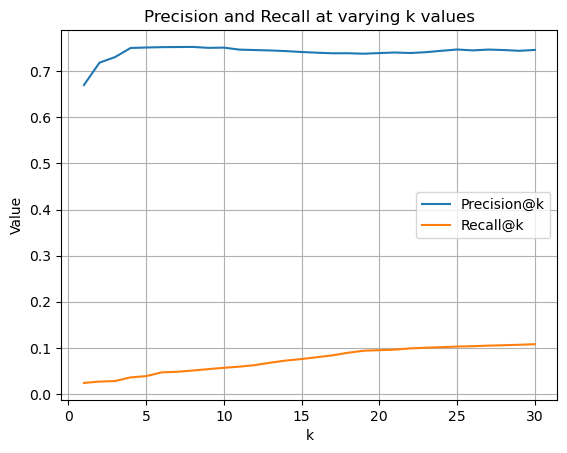

In [27]:
def get_precision_recall_at_k_range(model, data, k_range, threshold=91):
    k_fold = KFold(n_splits=5, random_state=42)
    precision_k_values = []
    recall_k_values = []

    for k in k_range:
        precisions_list = []
        recalls_list = []

        for trainset, testset in k_fold.split(data):
            model.fit(trainset)
            predictions = model.test(testset)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=threshold)

            precisions_list.append(sum(prec for prec in precisions.values()) / len(precisions))
            recalls_list.append(sum(rec for rec in recalls.values()) / len(recalls))

        precision_k_values.append(sum(precisions_list) / len(precisions_list))
        recall_k_values.append(sum(recalls_list) / len(recalls_list))

    return precision_k_values, recall_k_values

# Create an instance of the SVD model with default parameters
default_svd = SVD(random_state=42)

k_range = range(1, 31)  # Vary the value of k from 1 to 30

# Pass the default_svd model to the function instead of the tuned_svd model
precision_values, recall_values = get_precision_recall_at_k_range(default_svd, data, k_range)

# Plot the precision and recall values against the value of k
plt.plot(k_range, precision_values, label="Precision@k")
plt.plot(k_range, recall_values, label="Recall@k")
plt.xlabel("k")
plt.ylabel("Value")
plt.title("Precision and Recall at varying k values")
plt.legend()
plt.grid()
plt.show()

We may observe that as k increases, Precision@k hovers around 0.7 and Recall@k increases marginally to 0.1.

In other words, if a user is given 10 recommendations, 7 of those recommendations would be wines that the user might enjoy or find suitable, and on average, the recommender is only able to identify about 1 out of all relevant wines for a user within the top 10 recommendations. 

As there is no significant improvement in Precision@k and Recall@k, we will not vary the value of k for our default SVD model.

In [19]:
def evaluate_thresholds(default_svd, data, thresholds):
    results = []
    for threshold in thresholds:
        k_fold = KFold(n_splits=5, random_state=42)
        precisions_list = []
        recalls_list = []

        for trainset, testset in k_fold.split(data):
            default_svd.fit(trainset)
            predictions = default_svd.test(testset)
            precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=threshold)

            precisions_list.append(sum(prec for prec in precisions.values()) / len(precisions))
            recalls_list.append(sum(rec for rec in recalls.values()) / len(recalls))

        precision = sum(precisions_list) / len(precisions_list)
        recall = sum(recalls_list) / len(recalls_list)
        results.append({
            'Threshold': threshold,
            'Precision@k': precision,
            'Recall@k': recall,
        })

    results_df = pd.DataFrame(results)
    results_df['F1-score'] = 2 * (results_df['Precision@k'] * results_df['Recall@k']) / (results_df['Precision@k'] + results_df['Recall@k'])
    results_df = results_df[['Threshold', 'Precision@k', 'Recall@k', 'F1-score']]
    return results_df

#### Collaborative Filtering Only

In [20]:
# Define a new user
new_user_id = df['user_id'].max() + 1

# Define attributes
desired_attributes = {'light', 'sweet', 'citrus'}

# Sort wines by points in descending order
df_sorted = df.sort_values('points', ascending=False)

# Filter wines based on desired attributes
filtered_wines = df_sorted[df_sorted['tokens'].apply(lambda tokens: all(attribute in tokens for attribute in desired_attributes))]

print("Number of wines with desired attribute(s):", len(filtered_wines))

# Generate predicted ratings for the new user for each filtered wine
predicted_ratings = []
for wine_id in filtered_wines['wine_id']:
    predicted_rating = default_svd.predict(new_user_id, wine_id)
    predicted_ratings.append((wine_id, predicted_rating.est))

# Sort the wines based on the predicted ratings
sorted_predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

# Retrieve the top 10 recommendations
top_10_recommendations = sorted_predicted_ratings[:10]

# Compare the estimated ratings to the actual ratings
recommended_wines = pd.DataFrame(top_10_recommendations, columns=['wine_id', 'estimated_rating'])
recommended_wines = recommended_wines.merge(df[['wine_id', 'title', 'points']], on='wine_id')

# Sort by 'points' in descending order
recommended_wines = recommended_wines.sort_values(by='points', ascending=False)

print("Top 10 Recommendations for new user with Desired Attributes:")
recommended_wines

Number of wines with desired attribute(s): 17
Top 10 Recommendations for new user with Desired Attributes:


,wine_id,estimated_rating,title,points
0,87272,91.70127,Rosenhof 2015 Orion Eiswein Grüner Veltliner (...,95
1,115007,91.70127,Dr. Loosen 2009 Ürziger Würzgarten Auslese Rie...,94
2,122068,91.70127,Tapteil Vineyard 2011 Argus Bone Dry Riesling ...,92
3,185700,91.70127,Emile Beyer 2016 Tradition Gewurztraminer (Als...,92
4,6595,91.70127,Fiddlehead 2014 Goosebury Sauvignon Blanc (San...,92
5,95923,91.70127,Qupé 2015 Sawyer-Lindquist Vineyard Marsanne (...,91
6,192142,91.70127,Dr. Heidemanns-Bergweiler 2016 Bernkasteler al...,91
7,150610,91.70127,Lincourt 2014 Courtney's Chardonnay (Sta. Rita...,91
8,164023,91.70127,Weingut Binz 2015 Nackenheimer Engelsberg Beer...,91
9,206665,91.70127,Gérard Bertrand 2019 Côte des Roses Rosé (Lang...,91


Why do we have the same estimated rating for all recommendations?

Since our new user has no historical rating data, the model falls back to its global mean and biases, which results in the same predicted ratings for all wines.

We will now incorporate content-based features into the model, creating a hybrid recommendation system. This approach would allow it to provide more diverse recommendations based on both collaborative filtering and content-based information.

In [21]:
# Combine tokens into a single string for each wine
df['tokens_str'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Create a TfidfVectorizer
tvec = TfidfVectorizer(min_df=5, max_df=0.95, max_features=200, ngram_range=(1, 2), sublinear_tf=True)

# Fit the vectorizer to the 'tokens' column and transform the tokens into vectors
tmat = tvec.fit_transform(df['tokens_str'])

# Get the vocabulary
tfidf_vocab = tvec.get_feature_names_out()

In [22]:
# Calculate average tf-idf values for each feature
average_tfidf = np.mean(tmat, axis=0).A1

# Sort the features by their average tf-idf values in descending order
sorted_indices = np.argsort(average_tfidf)[::-1]

# Select the top 150 features
top_features = sorted_indices[:150]

# Get the feature names for the top 150 features
attributes = [tfidf_vocab[index] for index in top_features]

print(attributes)

['fruit', 'tannin', 'black', 'cherry', 'ripe', 'aroma', 'rich', 'spice', 'full', 'red', 'oak', 'note', 'blackberry', 'plum', 'berry', 'fresh', 'dark', 'dry', 'apple', 'bodied', 'lemon', 'white', 'juicy', 'balanced', 'herb', 'firm', 'raspberry', 'black cherry', 'pepper', 'bright', 'year', 'full bodied', 'cabernet', 'citrus', 'pear', 'vanilla', 'light', 'chocolate', 'dried', 'crisp', 'mineral', 'black fruit', 'peach', 'balance', 'currant', 'dense', 'aging', 'wood', 'soft', 'savory', 'complex', 'sweet', 'spicy', 'elegant', 'smooth', 'licorice', 'vintage', 'orange', 'green', 'sauvignon', 'tobacco', 'strawberry', 'leather', 'fruity', 'pinot', 'wine', 'earthy', 'lime', 'creamy', 'vineyard', 'tart', 'lead', 'cassis', 'hint', 'clove', 'young', 'syrah', 'tannic', 'intense', 'grape', 'flower', 'minerality', 'earth', 'stone', 'medium', 'tight', 'toast', 'complexity', 'powerful', 'cabernet sauvignon', 'barrel', 'merlot', 'layer', 'yellow', 'textured', 'come', 'smoky', 'there', 'grapefruit', 'rose'

The above features are our tokens with the highest average TF-IDF values, which will be used as an input for our Streamlit app to allow users to select their desired wine attributes.

#### Calculate cosine similarity between each wine's tokens and user desired attributes

By calculating cosine similarity, we can find wines that are most similar to the user's desired attributes.

By combining the predicted ratings for each wine (based on the user's preference) with these cosine similarity scores, we can then create a hybrid recommendation score.

This approach effectively takes both content-based and collaborative filtering into account, resulting in a hybrid recommendation system. 

In [23]:
# Create a dictionary to map wine_id to index
wine_id_to_index = df.reset_index().set_index('wine_id')['index'].to_dict()

# Define a function to compute cosine similarity
def calculate_cosine_similarity(wine_id, desired_attributes):
    wine_vector = tmat[df.index.get_loc(wine_id)]

     # Filter out attributes that are not in the vocabulary
    filtered_attributes = [attribute for attribute in desired_attributes if attribute in tfidf_vocab]

    # If all attributes are not in the vocabulary, return 0 as the similarity
    if not filtered_attributes:
        return 0
    
    desired_attributes_vector = tvec.transform([' '.join(desired_attributes)])
    similarity = cosine_similarity(wine_vector, desired_attributes_vector)
    return similarity[0][0]

In [24]:
# Define a function to scale a value to a specified range
def scale_value(value, old_min, old_max, new_min, new_max):
    return ((value - old_min) * (new_max - new_min)) / (old_max - old_min) + new_min

In [25]:
def hybrid_recommendations(user_id, desired_attributes, n=10):
    
    # Get predicted ratings for all wines
    predicted_ratings = []
    for wine_id in df['wine_id']:
        predicted_rating = default_svd.predict(user_id, wine_id)
        predicted_ratings.append((wine_id, predicted_rating.est))
    
    # Calculate cosine similarity between desired_attributes and wine tokens
    similarities = []
    for wine_id in df['wine_id']:
        similarity = calculate_cosine_similarity(wine_id, desired_attributes)
        similarities.append((wine_id, similarity))
    
    # Calculate combined ratings
    combined_ratings = []
    for i, wine_id in enumerate(df['wine_id']):
        scaled_similarity = scale_value(similarities[i][1], 0, 1, 90, 100)
        combined_rating = predicted_ratings[i][1] * 0.8 + scaled_similarity * 0.2
        combined_ratings.append((wine_id, combined_rating))
    
    # Filter out wines that do not contain all desired attributes
    combined_ratings_filtered = [(wine_id, rating) for wine_id, rating in combined_ratings if all(attribute in df.loc[wine_id_to_index[wine_id], 'tokens'] for attribute in desired_attributes)]

    # If there are no wines with the desired attributes, return the top 10 recommendations based on predicted ratings
    if not combined_ratings_filtered:
        sorted_predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)
        top_recommendations = sorted_predicted_ratings[:n]
    else:
        # Sort the wines based on the combined ratings
        sorted_combined_ratings = sorted(combined_ratings_filtered, key=lambda x: x[1], reverse=True)

        # Retrieve the top 10 recommendations
        top_recommendations = sorted_combined_ratings[:n]

    # Create a dataframe with the recommended wines
    recommended_wines = pd.DataFrame(top_recommendations, columns=['wine_id', 'combined_rating'])
    recommended_wines = recommended_wines.merge(df[['wine_id', 'title', 'points', 'variety']], on='wine_id')

    # Remove duplicate titles
    recommended_wines = recommended_wines.drop_duplicates(subset=['title'])

    # Get the top 10 unique recommendations
    recommended_wines = recommended_wines.head(10)

    return recommended_wines

Note that the 80% weightage for predicted ratings and 20% weightage for cosine similarity is arbitrary. 

After experimenting with an equal weightage, the results appeared too skewed towards the cosine similarity. 

Hence, I decided to increase the weightage for predicted ratings to 80% and decrease the weightage for cosine similarity to 20%.

In [28]:
# Define a new user
new_user_id = df['user_id'].max() + 1

desired_attributes = {'light', 'sweet', 'citrus'}

# Sort wines by points in descending order
df_sorted = df.sort_values('points', ascending=False)

# Filter wines based on desired attributes
filtered_wines = df_sorted[df_sorted['tokens'].apply(lambda tokens: all(attribute in tokens for attribute in desired_attributes))]

# Get the recommendations
recommended_wines = hybrid_recommendations(new_user_id, desired_attributes)
print("Number of wines with desired attribute(s):", len(filtered_wines))
print("Top 10 Recommendations for new user with Desired Attributes (Hybrid Approach):")
recommended_wines

Number of wines with desired attribute(s): 17
Top 10 Recommendations for new user with Desired Attributes (Hybrid Approach):


,wine_id,combined_rating,title,points,variety
0,8775,92.849384,Lincourt 2014 Courtney's Chardonnay (Sta. Rita...,91,Chardonnay
2,95923,92.588226,Qupé 2015 Sawyer-Lindquist Vineyard Marsanne (...,91,Marsanne
4,115007,92.565362,Dr. Loosen 2009 Ürziger Würzgarten Auslese Rie...,94,Riesling
5,164023,92.402026,Weingut Binz 2015 Nackenheimer Engelsberg Beer...,91,Riesling
6,185700,92.385756,Emile Beyer 2016 Tradition Gewurztraminer (Als...,92,Gewürztraminer
7,6595,92.374515,Fiddlehead 2014 Goosebury Sauvignon Blanc (San...,92,Sauvignon Blanc
8,34864,92.354258,Beresan 2007 Sémillon (Walla Walla Valley (WA)),90,Sémillon
9,206665,92.273454,Gérard Bertrand 2019 Côte des Roses Rosé (Lang...,91,Rosé


We have now created a personalised wine recommender using a hybrid approach:
- compute the predicted ratings for all wines using SVD (collaborative filtering) 
- calculate the cosine similarities between the user's desired attributes and our wine tokens (content-based filtering)

---
## Conclusion
---


| Algorithm                         | RMSE     | Precision@k (%)| Recall@k (%)|
|-----------------------------------|----------|:-----------:|:--------:|
| Normal Predictor                  | 2.176 |   57.0  | 16.3 |
| Baseline Predictor                | 1.614 |   72.4  | 9.6 |
| KNN Basic                         | 1.632 |   59.9  | 19.8 |
| KNN with Means                    | 1.632 |   57.5  | 19.2 |
| KNN with Z-score                  | 1.632 |   58.9  | 19.9 |
| KNN Baseline                      | 1.614 |   72.1  | 9.2 |
| **SVD**                           | **1.615** | **73.8**|**6.6**|
| SVD (tuned)                    | 1.615 |   72.7  | 8.8 |
| Non-negative Matrix Factorization | 1.632 |   59.7  | 19.1 |
| Co-Clustering                     | 1.632 |   57.3  | 18.5 |

In conclusion, SVD (before tuning) has the best overall performance for the wine recommender as it has the lowest RMSE and the highest Precision@k. At 74%, it is relatively high, meaning that users are more likely to receive recommendations that they will enjoy, thus increasing user satisfaction and trust in the recommendations. However, it has the lowest recall, suggesting that it may not be capturing all the relevant wines for a user within the top k recommendations, like NMF.

Overall, as our aim is to prioritize the quality of recommendations (i.e., how well the predicted ratings match the actual ratings and the relevance of recommended items), SVD would do a good job for our wine recommender.

---
## Limitations
---

The SVD algorithm, while providing the highest precision, has a low recall value. This indicates that it may not be capturing all relevant wines for the user, even though the top k recommendations are mostly accurate.

Many of the algorithms have low recall values, which could be a sign that this approach may not be the best fit for this particular problem or dataset.

---
## Recommendations
---

To improve the recall@k without sacrificing precision, additional features or metadata about the wines (e.g., grape variety, region, or tasting notes) to enhance the recommendation algorithm could be explored. 

We can consider segmenting users based on their preferences or behaviors to tailor the recommendations more effectively. Personalized recommendations can lead to improved user satisfaction and better overall performance of the recommender system.

Lastly, we can perform A/B testing with different algorithms or different configurations of the chosen algorithm to find the most effective solution for our users. This approach allows us to compare the performance of different algorithms in a controlled environment and make data-driven decisions about which algorithm to use.